In [1]:
import math
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import Callback
from keras.models import load_model
import os
import cv2 as cv
import matplotlib.pyplot as plt
from Citra import Citra

Using TensorFlow backend.


In [2]:
class StopLearning(Callback):
    
    def __init__(self, X, Y):
        super(Callback, self).__init__()
        self.X = X
        self.Y = Y
    
    def on_epoch_end(self, epoch, logs = {}):
        loss, acc = self.model.evaluate(self.X, self.Y, verbose = 0)
#         print('Akurasi : ' + str(acc * 100) + '\n')
        
        if acc > 0.99:
            self.model.stop_training = True
            
        if acc >= 0.92:
            self.model.save('hasil learning/Model NN ' + str(acc * 100) + '.h5')
#             print("Saved model to disk\n")
            
def getTrainingData(path, label, limit):
    trainImages = []
    
    c = 1
    for file in os.listdir(path):
        if file.endswith('.png') == False:
            continue
            
        filePath = os.path.join(path, file)
        img = Citra(cv.imread(filePath))
        img.resize((128, 128))
        trainImages.append([img.getHistogram(), label])
        
        if c == limit:
            break
            
        c += 1
        
    return numpy.array(trainImages)

In [3]:
k1 = getTrainingData('data/Dataset/v2/1', [1 ,0, 0, 0], 80)
k2 = getTrainingData('data/Dataset/v2/2', [0, 1, 0, 0], 80)
k3 = getTrainingData('data/Dataset/v2/3', [0, 0, 1, 0], 80)
k4 = getTrainingData('data/Dataset/v2/4', [0, 0, 0, 1], 80)
training_images = numpy.concatenate((k1, k2, k3, k4), axis = 0)
training_data = numpy.array([i[0] for i in training_images])
training_label = numpy.array([i[1] for i in training_images])

In [4]:
# 1. define the network
model = Sequential()
model.add(Dense(500, input_dim = 768, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(200, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
# 2. compile the network
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# 3. fit the network
history = model.fit(training_data, training_label, epochs = 1, batch_size = 20, verbose = 1, callbacks = [StopLearning(training_data, training_label)])
# 4. evaluate the network
loss, accuracy = model.evaluate(training_data, training_label)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))
# 5. make predictions
probabilities = model.predict(training_data)
# print(probabilities)
predictions = numpy.argmax(probabilities, axis=1)
# print(predictions)
accuracy = numpy.mean(predictions == numpy.argmax(training_label, axis=1))
print("Prediction Accuracy: %.2f%%" % (accuracy*100))

Epoch 1/1
320/320 [==============================] - 0s 287us/step

Loss: 1.27, Accuracy: 52.81%
Prediction Accuracy: 52.81%


In [6]:
model.save('hasil learning/nn1.h5')

In [14]:
loaded_model = load_model('hasil learning/Model NN 94.375.h5')
loaded_model.compile(loss = 'categorical_crossentropy', optimizer= 'sgd', metrics=['accuracy'])
fit = loaded_model.fit(x = training_data, y = training_label, epochs = 3000, batch_size = 30, verbose = 0, callbacks = [StopLearning(training_data, training_label)])
        
loaded_model.summary()
loss, accuracy = loaded_model.evaluate(training_data, training_label)
print('Akurasi :' + str(accuracy * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 600)               461400    
_________________________________________________________________
dropout_24 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 450)               270450    
_________________________________________________________________
dropout_25 (Dropout)         (None, 450)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 250)               112750    
_________________________________________________________________
dropout_26 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 1004      
Total para

error: OpenCV(3.4.3) c:\projects\opencv-python\opencv\modules\imgproc\src\color.hpp:255: error: (-2:Unspecified error) in function '__cdecl cv::CvtHelper<struct cv::Set<3,4,-1>,struct cv::Set<3,4,-1>,struct cv::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


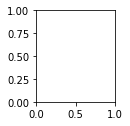

In [9]:
from NNModel import NNModel
fig = plt.figure(figsize = (20, 40))
indeks = ['mentah', 'setah', 'setang', 'matang']

model = NNModel('hasil learning/nn1.h5', 'categorical_crossentropy', 'sgd')
model.outputClass = indeks

for counter, data in enumerate(training_data):
    y = fig.add_subplot(20, 12, counter + 1)
    img = Citra(training_data[counter])
    histogram = img.getHistogram()
    output = model.predict(numpy.array([histogram]))
    
    y.imshow(cv.cvtColor(training_data[counter], cv.COLOR_BGR2RGB))
    plt.title(indeks[numpy.argmax(output)])
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)